1. Density Peaks & Distribution

Males (blue dashed lines) generally have peaks slightly higher on the right side of the x-axis (log message length), around 4–5, meaning male authors tend to send slightly longer messages on average.

Females (red dashed lines) show a peak slightly lower, around 3–4, so female authors tend to send shorter messages on average in this dataset.

2. Variation Between Authors

Both genders show multiple dashed lines, meaning individual authors have variability.

Some male and female authors have similar peaks; the distributions overlap significantly, so message length isn’t strictly gendered, but there is a trend toward males writing longer messages.

3. Spread

Both male and female distributions have long tails toward higher log lengths, meaning occasionally, authors of both genders send very long messages.

Most activity is concentrated in the 3–5 log length range, which seems to be the typical message length cluster for your group.

4. Overall Gender Insight

Male authors in this WhatsApp group are slightly more likely to send longer messages, while females send slightly shorter messages, but there’s considerable overlap—gender differences are subtle, not extreme.

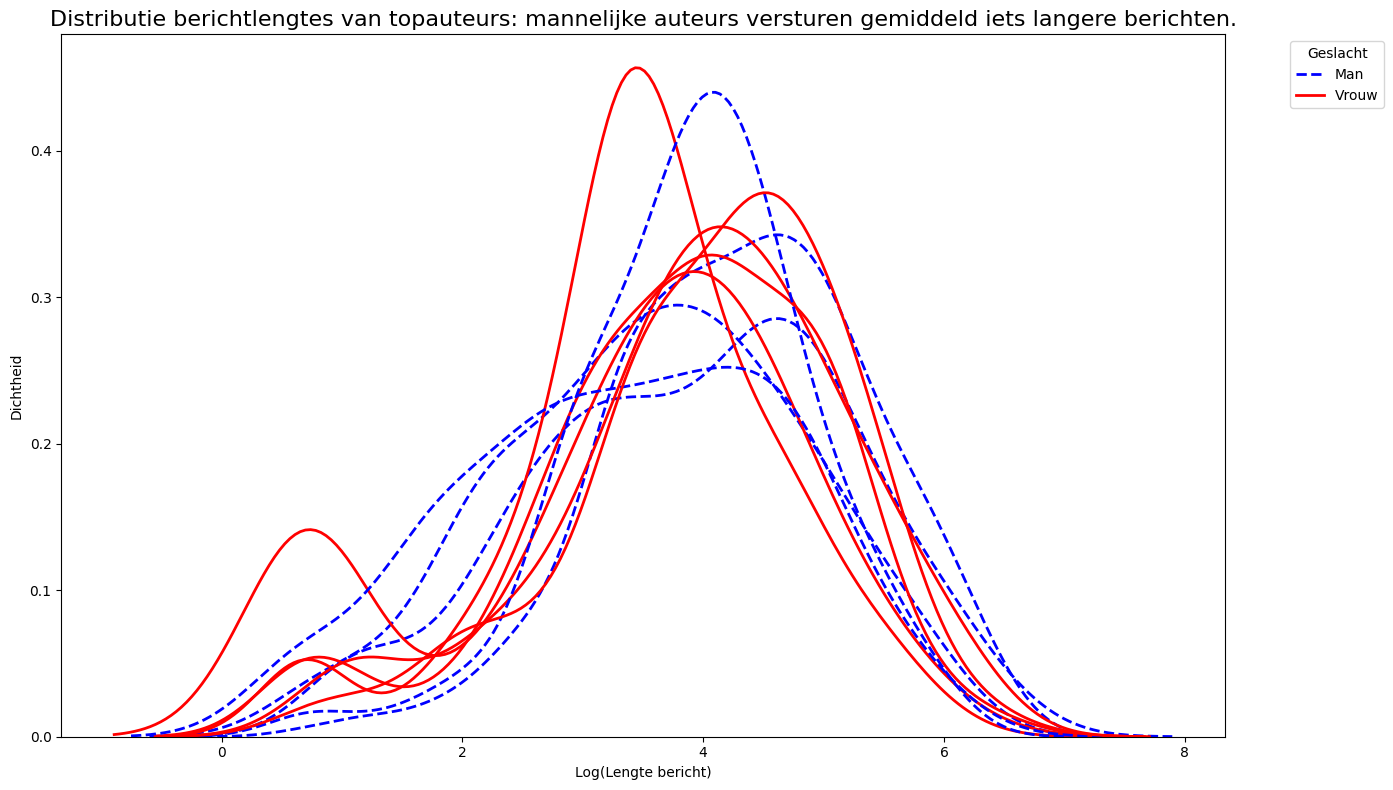

In [ ]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import tomllib
import json
from loguru import logger
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load WhatsApp data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run preprocess first!")
df = pd.read_parquet(datafile)

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
    [['author', 'Name', 'Gender']]
)

# %%
# --- Compute top 10 authors, can be male or female ---
top_authors = df['author'].value_counts().head(10).index.tolist()

# Filter dataframe for top authors only
df_top = df[df['author'].isin(top_authors)].copy()

# Map author IDs to names and gender
author_map = dict(zip(author_info_df['author'], author_info_df['Name']))
gender_map = dict(zip(author_info_df['author'], author_info_df['Gender']))

df_top['author_name'] = df_top['author'].map(author_map)
df_top['author_name'].fillna(df_top['author'], inplace=True)

df_top['author_gender'] = df_top['author'].map(gender_map)
df_top['author_gender'].fillna('Unknown', inplace=True)

# %%
# --- Optional: filter extreme message lengths ---
df_top = df_top[df_top['msg_length'] <= 800]
df_top['log_msg_length'] = df_top['msg_length'].apply(lambda x: np.log(x + 1))


# --- Plot KDEs with gender-specific line styles (Dutch legend) ---
plt.figure(figsize=(14, 8))

# Define gender colors
gender_colors = {'Male': 'blue', 'Female': 'red', 'Unknown': 'gray'}

# Define gender line styles
gender_linestyles = {'Male': '--', 'Female': '-', 'Unknown': '--'}  # Female solid, others dashed

# Translation for legend
gender_labels_dutch = {'Male': 'Man', 'Female': 'Vrouw', 'Unknown': 'Onbekend'}

# Keep track of which genders are already added to legend
legend_added = set()

for author in df_top['author_name'].unique():
    author_data = df_top[df_top['author_name'] == author]
    gender = author_data['author_gender'].iloc[0]
    color = gender_colors.get(gender, 'gray')
    linestyle = gender_linestyles.get(gender, '--')
    
    # Translate gender for legend
    label = gender_labels_dutch.get(gender, 'Onbekend') if gender not in legend_added else None
    if label is not None:
        legend_added.add(gender)
    
    sns.kdeplot(
        data=author_data,
        x='log_msg_length',
        fill=False,
        common_norm=False,
        linestyle=linestyle,
        linewidth=2,
        color=color,
        label=label
    )

plt.legend(title="Geslacht", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distributie berichtlengtes van topauteurs: mannelijke auteurs versturen gemiddeld iets langere berichten.", fontsize=16)
plt.xlabel("Log(Lengte bericht)")
plt.ylabel("Dichtheid")
plt.tight_layout()
plt.show()




